# A Novel Approach for a Three-Way Classification of Lumbar Spine Degeneration using Multimodality

## Libs

In [169]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
from matplotlib.patches import Circle
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

### Predictable CSV for severity levels

In [12]:
base_data = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
base_data.head(5)

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


### XY Coordinates CSV that tells where is degeneration is

This is the most most important and joining linkage of the whole dataset, this is exactlty what we are working on regenerating.


In [118]:
label_data = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

path_list = []
for study_id, series_id, instance_number in zip(label_data['study_id'], label_data['series_id'], label_data['instance_number']):
    path_list.append(f'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{study_id}/{series_id}')

label_data['dcm_path'] = path_list
label_data.head(5)

,study_id,series_id,instance_number,condition,level,x,y,dcm_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [119]:
print(label_data[['condition']].value_counts())
print(label_data['level'].value_counts())

condition                       
Left Neural Foraminal Narrowing     9860
Right Neural Foraminal Narrowing    9859
Spinal Canal Stenosis               9753
Right Subarticular Stenosis         9612
Left Subarticular Stenosis          9608
Name: count, dtype: int64
level
L3/L4    9858
L4/L5    9858
L5/S1    9845
L2/L3    9661
L1/L2    9470
Name: count, dtype: int64


In [15]:
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
 7   dcm_path         48692 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 3.0+ MB


### CSV that tells the angle/mode of MRI

In [109]:
description_data = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
description_data.head(5)

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [105]:
description_data['series_description'].value_counts()

series_description
Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: count, dtype: int64

In [107]:
merged_df = pd.merge(base_data, label_data, on='study_id', how='inner')
merged_df = pd.merge(description_data, merged_df, on='series_id', how='inner')

merged_df['severity_level'] = None
merged_df['condition_combined'] = None

severities = []
conditions = []

for i in tqdm(range(merged_df.shape[0])):
    res = str(base_data[base_data['study_id'] == merged_df.loc[i, 'study_id']][(merged_df.loc[i, "condition"] + ' ' + merged_df.loc[i, "level"]).replace(' ', '_').replace('/', '_').replace(',', '').lower()]).split()
    severities.append(res[1])
    conditions.append(res[3].replace(',', ''))

merged_df['severity_level'] = severities
merged_df['condition_combined'] = conditions
merged_df.drop(columns = ['spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
       'right_subarticular_stenosis_l4_l5',
       'right_subarticular_stenosis_l5_s1'], inplace = True)

100%|██████████| 48692/48692 [00:42<00:00, 1136.74it/s]


In [110]:
merged_df.columns

Index(['series_id', 'series_description', 'study_id', 'instance_number',
       'condition', 'level', 'x', 'y', 'dcm_path', 'severity_level',
       'condition_combined'],
      dtype='object')

In [120]:
complete_df = pd.merge(
    description_data[['series_id', 'study_id', 'series_description']],
    merged_df[['series_id', 'study_id', 'condition', 'level', 'severity_level', 'dcm_path']],
    on='series_id',
    how='inner'
)

complete_df['severity_level'] = complete_df['severity_level'].fillna('no degeneration')
complete_df['condition'] = complete_df['condition'].fillna('no condition')
complete_df['level'] = complete_df['level'].fillna('no level')

complete_df.drop(columns = ['study_id_y'], inplace=True)
complete_df.rename(columns={'study_id_x':'study_id'}, inplace=True)

In [121]:
complete_df

,series_id,study_id,series_description,condition,level,severity_level,dcm_path
0,702807833,4003253,Sagittal T2/STIR,Spinal Canal Stenosis,L1/L2,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,702807833,4003253,Sagittal T2/STIR,Spinal Canal Stenosis,L2/L3,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,702807833,4003253,Sagittal T2/STIR,Spinal Canal Stenosis,L3/L4,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,702807833,4003253,Sagittal T2/STIR,Spinal Canal Stenosis,L4/L5,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,702807833,4003253,Sagittal T2/STIR,Spinal Canal Stenosis,L5/S1,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
...,...,...,...,...,...,...,...
48687,4237840455,4290709089,Sagittal T1,Left Neural Foraminal Narrowing,L1/L2,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48688,4237840455,4290709089,Sagittal T1,Left Neural Foraminal Narrowing,L2/L3,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48689,4237840455,4290709089,Sagittal T1,Left Neural Foraminal Narrowing,L3/L4,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48690,4237840455,4290709089,Sagittal T1,Left Neural Foraminal Narrowing,L4/L5,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


### Mapping Necessary MRIs to Conditions

In [127]:
tqdm.pandas()

conditions_to_drop = (
    ((complete_df["series_description"] == "Sagittal T2/STIR") & (complete_df["condition"] != "Spinal Canal Stenosis")) |
    ((complete_df["series_description"] == "Axial T2") & (complete_df["condition"] != "Right Subarticular Stenosis") & (complete_df["condition"] != "Left Subarticular Stenosis")) |
    ((complete_df["series_description"] == "Sagittal T1") & (complete_df["condition"] != "Left Neural Foraminal Narrowing") & (complete_df["condition"] != "Right Neural Foraminal Narrowing"))
)

complete_df = complete_df[~conditions_to_drop].reset_index(drop=True)

In [162]:
d = list(complete_df[complete_df['severity_level'] == 'NaN']['study_id'].unique())
complete_df = complete_df[~complete_df['study_id'].isin(d)]

In [164]:
complete_df.sample(5)

,series_id,study_id,series_description,condition,level,severity_level,dcm_path
30104,1479349817,2676098721,Sagittal T1,Right Neural Foraminal Narrowing,L4/L5,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4007,3537936889,339664659,Axial T2,Right Subarticular Stenosis,L1/L2,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
6898,338048129,625376596,Axial T2,Left Subarticular Stenosis,L4/L5,Normal/Mild,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
10357,503399625,937772835,Sagittal T2/STIR,Spinal Canal Stenosis,L2/L3,Moderate,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
19152,271934733,1722308532,Sagittal T1,Left Neural Foraminal Narrowing,L4/L5,Moderate,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [167]:
scs = complete_df[complete_df["condition"] == "Spinal Canal Stenosis"]
lnfn = complete_df[complete_df["condition"] == "Left Neural Foraminal Narrowing"]
rnfn = complete_df[complete_df["condition"] == "Right Neural Foraminal Narrowing"]
rss = complete_df[complete_df["condition"] == "Right Subarticular Stenosis"]
lss = complete_df[complete_df["condition"] == "Left Subarticular Stenosis"]

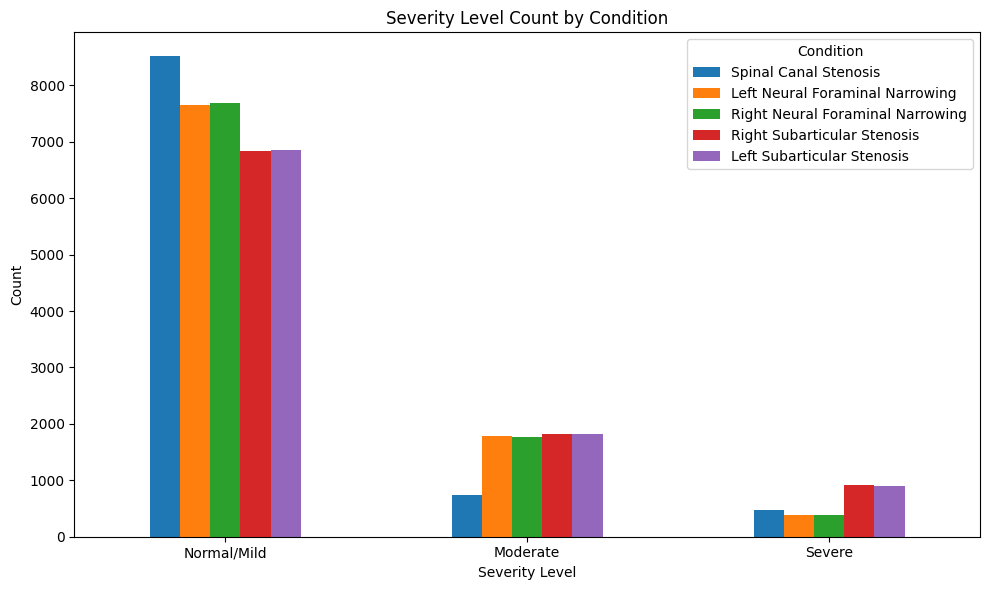

In [170]:
scs_counts = scs['severity_level'].value_counts()
lnfn_counts = lnfn['severity_level'].value_counts()
rnfn_counts = rnfn['severity_level'].value_counts()
rss_counts = rss['severity_level'].value_counts()
lss_counts = lss['severity_level'].value_counts()

severity_df = pd.DataFrame({
    'Spinal Canal Stenosis': scs_counts,
    'Left Neural Foraminal Narrowing': lnfn_counts,
    'Right Neural Foraminal Narrowing': rnfn_counts,
    'Right Subarticular Stenosis': rss_counts,
    'Left Subarticular Stenosis': lss_counts
}).fillna(0)

severity_df.plot(kind='bar', figsize=(10, 6))

plt.title('Severity Level Count by Condition')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title="Condition")
plt.tight_layout()

plt.show()

### Human Annotated Degeneration/Spinal Conditions

In [171]:
condition_colors = {
    'Spinal Canal Stenosis': 'red',
    'Right Neural Foraminal Narrowing': 'pink',
    'Left Neural Foraminal Narrowing': 'pink',
    'Left Subarticular Stenosis': 'yellow',
    'Right Subarticular Stenosis': 'yellow'
}

def display_mri_with_circles(ax, dcm_path, coordinates, conditions):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array
    ax.imshow(img, cmap='gray')
    
    for (x, y, condition) in zip(coordinates['x'], coordinates['y'], conditions):
        color = condition_colors.get(condition, 'white')
        circle = Circle((x, y), 10, color=color, fill=True, linewidth=1, alpha=0.5)
        ax.add_patch(circle)
    
    ax.axis('off')

def display_images_in_grid(label_data, study_id):
    selected_data = label_data[label_data['study_id'] == study_id]
    grouped = selected_data.groupby('dcm_path').agg(list).reset_index()

    num_images = len(grouped)
    if num_images == 0:
        print(f"No images found for study_id: {study_id}")
        return
    
    grid_cols = math.ceil(math.sqrt(num_images))
    grid_rows = math.ceil(num_images / grid_cols)
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 10))
    
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for idx, (ax, row) in enumerate(zip(axes, grouped.iterrows())):
        dcm_path = row[1]['dcm_path']
        coordinates = {'x': row[1]['x'], 'y': row[1]['y']}
        conditions = row[1]['condition']
        
        display_mri_with_circles(ax, dcm_path, coordinates, conditions)
    
    for ax in axes[idx + 1:]:
        ax.axis('off')
    
    handles = [Circle((0, 0), 10, color=color, fill=True, linewidth = 1, alpha=0.5) for condition, color in condition_colors.items()]
    labels = list(condition_colors.keys())
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1), fontsize='small')
    
    plt.tight_layout()
    plt.show()

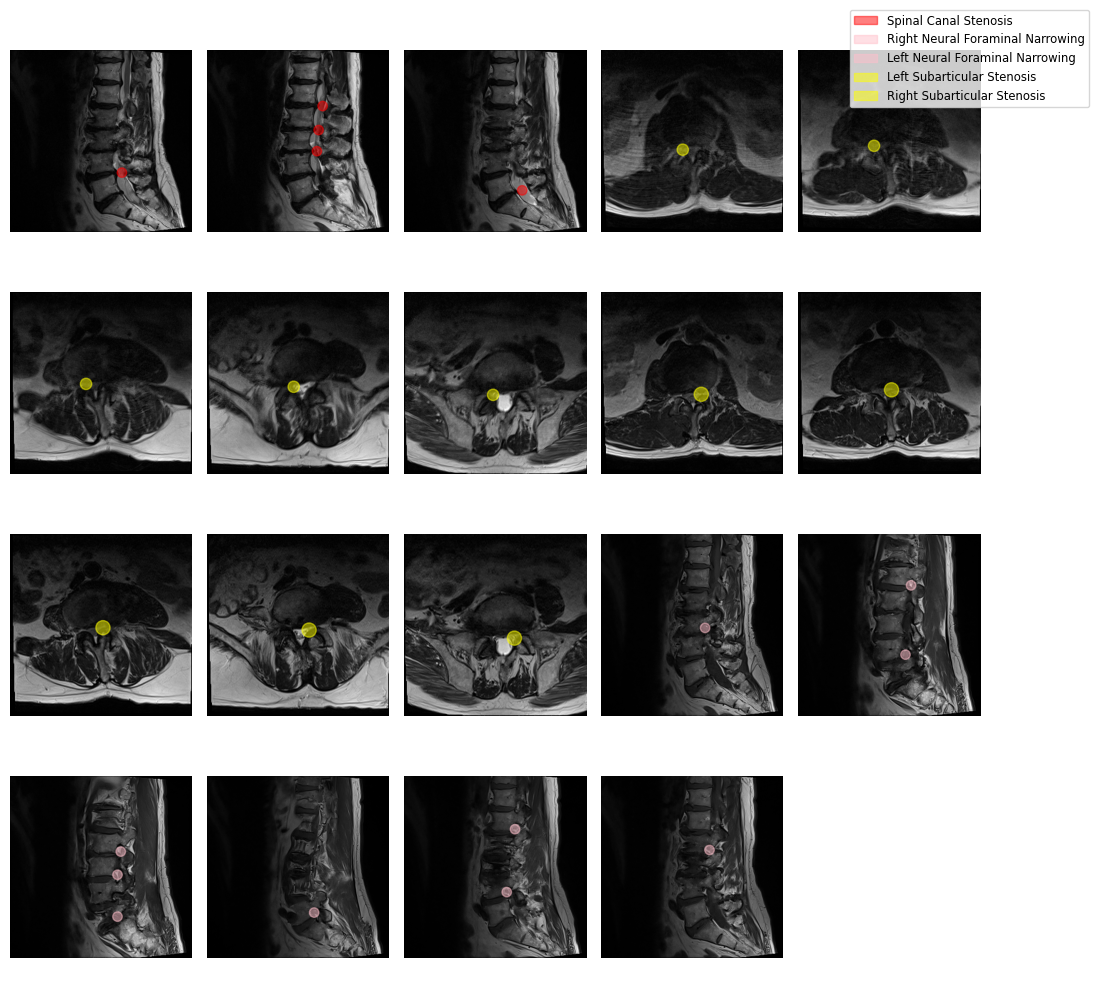

In [172]:
display_images_in_grid(merged_df, study_id=105895264)

## Preprocessing - I